In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

In [2]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

In [3]:
np.random.seed(123)

In [4]:
%load_ext rpy2.ipython

In [5]:
import pandas as pd

# Applications of SVD

## Reconstruction

In [6]:
iris = %R iris

TypeError: Parameter 'categories' must be list-like, was <rpy2.rinterface.StrSexpVector - Python:0x7f3fe3371de0 / R:0x56418551dbc8>

In [ ]:
X  = iris.iloc[:, :-1].values

In [ ]:
X[:5]

In [ ]:
U, s, Vt = la.svd(X, full_matrices=False)

In [ ]:
U.shape, s.shape, Vt.shape

In [ ]:
(U @ np.diag(s) @ Vt)[:5]

## PCA

Center the data

In [ ]:
Xc = X - X.mean(0)

In [ ]:
Xc[:5]

Find SVD

In [ ]:
U, s, Vt = la.svd(Xc, full_matrices=False)

PCA is $U \Sigma$

In [ ]:
Y = U[:, :2] @ np.diag(s[:2])

In [ ]:
plt.scatter(Y[:, 0], Y[:, 1],
            c=iris['Species'].astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

PCA is also $XV$

In [ ]:
Z = X @ Vt.T[:, :2]

In [ ]:
plt.scatter(Z[:, 0], Z[:, 1],
            c=iris['Species'].astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

Check with PCA routine. It should be the same (eigenvectors may flip)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
Y1 = pca.fit_transform(Xc)

In [ ]:
plt.scatter(Y1[:, 0], Y1[:, 1],
            c=iris['Species'].astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

Flip directions for the second eigenvector

In [ ]:
plt.scatter(Y1[:, 0], -Y1[:, 1],
            c=iris['Species'].astype('category').cat.codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

## Data compression (Low rank approximations)

In [7]:
X = np.ones((25, 15))
X[5:-5, 2:-2] = 0
X[8:-8, 6:-6] = 1

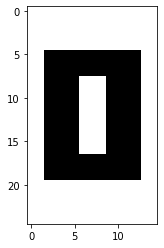

In [8]:
plt.imshow(X, cmap='gray')
pass

In [9]:
U, s, Vt = la.svd(X, full_matrices=False)

Note that there are only 3 types of columns, and so 3 singular values suffice to capture all the information.

In [10]:
np.cumsum(s)/s.sum()

array([ 0.6,  0.9,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,
        1.0,  1.0,  1.0,  1.0])

In [11]:
X1 = U[:, :3] @ np.diag(s[:3]) @ Vt[:3, :]

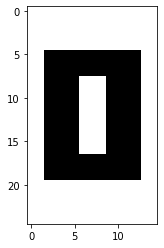

In [13]:
plt.imshow(X1, cmap='gray')
pass

Using MNIST example

In [14]:
mnist = pd.read_csv('https://pjreddie.com/media/files/mnist_test.csv')

In [15]:
mnist.shape

(9999, 785)

In [16]:
img = mnist.iloc[0, :-1].values.reshape((28,28))

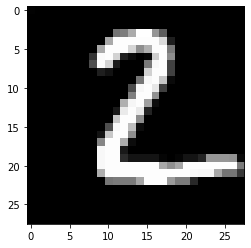

In [17]:
plt.imshow(img, cmap='gray')
pass

In [18]:
U, s, Vt = la.svd(img, full_matrices=False)

In [19]:
img1 = U[:, :1] @ np.diag(s[:1]) @ Vt[:1, :]

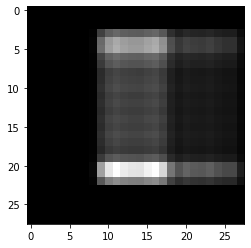

In [20]:
plt.imshow(img1, cmap='gray')
pass

In [21]:
np.cumsum(s)/s.sum()

array([ 0.3,  0.5,  0.6,  0.7,  0.8,  0.9,  0.9,  0.9,  0.9,  0.9,  1.0,
        1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,
        1.0,  1.0,  1.0,  1.0,  1.0,  1.0])

In [22]:
k = 6
imgk = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

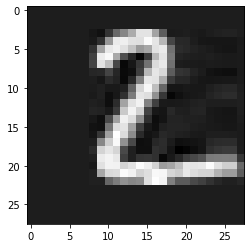

In [23]:
plt.imshow(imgk, cmap='gray')
pass

We get slightly more than 50% compression with $k=6$. Note that there are better methods for image compression.

In [ ]:
sizes = (U[:, :k].size, s[:k].size, Vt[:k, :].size)

In [ ]:
sizes

In [ ]:
img.size

In [ ]:
sum(sizes)

## Denoising

SVD by itself can do some denoising, but effective use requires more sophisticated algorithms such as [k-SVD](https://en.wikipedia.org/wiki/K-SVD)

In [24]:
img_noise = np.clip(img + np.random.normal(0, 30, img.shape), 0, 255)

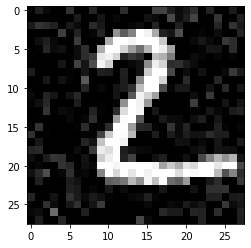

In [25]:
plt.imshow(img_noise, cmap='gray')
pass

In [26]:
U, s, Vt = la.svd(img_noise, full_matrices=False)

In [27]:
np.cumsum(s)/s.sum()

array([ 0.3,  0.4,  0.5,  0.6,  0.7,  0.7,  0.7,  0.8,  0.8,  0.8,  0.8,
        0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  1.0,  1.0,  1.0,  1.0,
        1.0,  1.0,  1.0,  1.0,  1.0,  1.0])

In [28]:
k = 6
imgk_noise = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

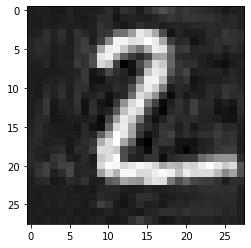

In [29]:
plt.imshow(imgk_noise, cmap='gray')
pass

## Recommender system

Based on toy example from this [blog post](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75)

In [ ]:
from collections import OrderedDict

We have a database of movies and user ratings, but since most users watch and rate only a small subset of all possible movies, there is a lot of missing data. Our job is to predict what other movies a user might like, based on the movies that the user has rated. 

Recall that SVD gives the optimal (in terms of Frobenius norm) low rank reconstruction for a matrix. This is true even for sparse matrices, and we make use of this to make predictions about user movie preferences.

Note: Real world recommender systems based on SVD calculate an approximate SVD using iterative methods for computational efficiency, but the idea is the same - we assume that the data can be modeled by $k$ latent factors, then reconstruct the rank-$k$ matrix. You'd also normalize the data in a real-use case.

In [30]:
ratings = pd.DataFrame([
    [2,None,2,4,5,None],
    [5,None,4,None,None,1],
    [None,None,5,None,2,None],
    [None,1,None,5,None,4],
    [None,None,4,None,None,2,],
    [4,5,None,1,None,None]],
    index=list('ABCDEF'),
    columns=['The Avengers', 'Sherlock', 'Transformers',
             'Matrix', 'Titanic', 'Me Before You']
)

In [31]:
ratings = ratings.astype(pd.SparseDtype("float", np.nan))
ratings

,The Avengers,Sherlock,Transformers,Matrix,Titanic,Me Before You
A,2.0,NaN,2.0,4.0,5.0,NaN
B,5.0,NaN,4.0,NaN,NaN,1.0
C,NaN,NaN,5.0,NaN,2.0,NaN
D,NaN,1.0,NaN,5.0,NaN,4.0
E,NaN,NaN,4.0,NaN,NaN,2.0
F,4.0,5.0,NaN,1.0,NaN,NaN


We need to deal with the sparsity.

In [32]:
from scipy.sparse.linalg import svds # sparse svd

In [33]:
X = ratings.sparse.to_coo()

In [34]:
print(X)

  (0, 0)	2.0
  (1, 0)	5.0
  (5, 0)	4.0
  (3, 1)	1.0
  (5, 1)	5.0
  (0, 2)	2.0
  (1, 2)	4.0
  (2, 2)	5.0
  (4, 2)	4.0
  (0, 3)	4.0
  (3, 3)	5.0
  (5, 3)	1.0
  (0, 4)	5.0
  (2, 4)	2.0
  (1, 5)	1.0
  (3, 5)	4.0
  (4, 5)	2.0


In [35]:
U, s, Vt = svds(X, k=min(ratings.shape)-1)

In [36]:
s

array([ 3.0,  4.9,  6.4,  6.9,  10.1])

svds gives singular values in ascending order, so we need to perform a permutation to get it in the fmiliar form.

In [37]:
perm = np.arange(len(s))[::-1]
U = U[:, perm]
s = s[perm]
Vt = Vt[perm, :]

In [38]:
k = 3
Y = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
Y

array([[ 1.4,  0.4,  2.9,  4.0,  2.7,  2.1],
       [ 4.0,  1.5,  4.2, -0.2,  1.0,  0.2],
       [ 0.9, -1.1,  4.6,  0.0,  1.8,  0.4],
       [ 0.3,  1.0, -0.6,  5.0,  1.9,  2.3],
       [ 0.7, -0.7,  3.3,  0.2,  1.4,  0.4],
       [ 4.7,  4.0, -0.2,  1.1, -0.5,  0.4]])

In [39]:
user = 'E'
pd.DataFrame(dict(
    Observed = ratings.loc[user].sparse.to_dense(),
    Predicted = Y[ratings.index.tolist().index(user)]))

,Observed,Predicted
The Avengers,NaN,0.749016
Sherlock,NaN,-0.688250
Transformers,4.0,3.292351
Matrix,NaN,0.243724
Titanic,NaN,1.360181
Me Before You,2.0,0.379015
